In [1]:
import numpy as np
import glob
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from bratsreg_model_stage import (
    SpatialTransform_unit, SpatialTransformNearest_unit,
)
from Functions import save_img
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score


In [2]:
num_d=1
result = "Result_D"

In [3]:
use_cuda=False
device = torch.device("cuda" if use_cuda else "cpu")
#transform = SpatialTransform_unit().to(device)
transform = SpatialTransformNearest_unit().to(device)

def transform_seg(num_d, result, direction="X_Y", GT=1):
    """
    Transform segmentation image to deformed image.
    :param num_d: number of deformation image
    :param result: folder name
    :param direction: direction of deformation
    """
    F_X_Y_file=f"../{result}/{num_d}F_X_Y.nii.gz"
    F_Y_X_file=f"../{result}/{num_d}F_Y_X.nii.gz"
    grid_unit_file=f"../{result}/{num_d}grid_unit.nii.gz"

    if GT == 1:
        # Load Numpy segmentation file
        segmentation_list = sorted(glob.glob("../Dataset/test/seg_out_*.npy"))
        # print(segmentation_list)
        seg_image_file= segmentation_list[num_d-1] #f"../{result}/{num_d}.npy"
        print(seg_image_file)
        # labels
        seg_out = np.load(seg_image_file)
        seg_out = torch.from_numpy(seg_out).to(device)
        seg_out = seg_out.unsqueeze(0).unsqueeze(1)
    else:
        segmentation_list = sorted(glob.glob("../Dataset/labels/*"))
        img = nib.load(segmentation_list[num_d-1])
        seg_out = img.get_fdata() #.astype(np.uint8)
        seg_out = torch.from_numpy(seg_out).to(device)
        seg_out = seg_out.unsqueeze(0).unsqueeze(1)

    # print(seg_out.shape)
    if direction == "X_Y":
        deformation_file= F_X_Y_file
    else:
        deformation_file= F_Y_X_file
        
    template = nib.load(deformation_file)
    header, affine = template.header, template.affine


    # Matriz de transformacion
    F_X_Y = torch.from_numpy(nib.load(F_X_Y_file).get_fdata()).to(device)
    F_X_Y = F_X_Y.unsqueeze(0)

    F_Y_X = torch.from_numpy(nib.load(F_Y_X_file).get_fdata()).to(device)
    F_Y_X = F_Y_X.unsqueeze(0)
    
    grid_unit = torch.from_numpy(nib.load(grid_unit_file).get_fdata()).to(device)
    grid_unit = grid_unit.unsqueeze(0)
    #print(F_X_Y.shape, F_Y_X.shape, grid_unit.shape)

    if direction == "X_Y": 
        warped_seg = transform(seg_out, F_X_Y.permute(0, 2, 3, 4, 1), grid_unit)
        if GT == 1:
            save_img(
                warped_seg.cpu().numpy()[0],
                f"../{result}/{num_d}segmentation.nii.gz",
                header,
                affine,
            )
        else:
            save_img(
                warped_seg.cpu().numpy()[0],
                f"../{result}/{num_d}segmentation_BraTS.nii.gz",
                header,
                affine,
            )
    else:
        warped_seg = transform(seg_out, F_Y_X.permute(0, 2, 3, 4, 1), grid_unit)
        if GT == 1:
            save_img(
                warped_seg.cpu().numpy()[0],
                f"../{result}/{num_d}segmentation_back.nii.gz",
                header,
                affine,
            )
        else:
            save_img(
                warped_seg.cpu().numpy()[0],
                f"../{result}/{num_d}segmentation_BraTS_back.nii.gz",
                header,
                affine,
            )

    print("Segmentation transformed: ", num_d)
    return warped_seg, header, affine

In [36]:
warped_seg, header, affine=transform_seg(num_d, result, direction='Y_X', GT=2)

Segmentation transformed:  1


## Transformar todas las segmentaciones

In [ ]:
result="Result_D"
for i in range(36):
    _,_,_=transform_seg(i+1, result, direction='Y_X', GT=2)

In [2]:
def display_slice(slice_data, title=None):
  plt.imshow(slice_data.squeeze(), cmap='gray')  # Squeeze to remove channel dim if present
  plt.colorbar()
  if title:
    plt.title(title)
  plt.show()

def display_slice_with_segmentation(mri_slice, segmentation_slice, title=None):
    plt.imshow(mri_slice.squeeze(), cmap='gray')  # Squeeze to remove channel dim if present
    plt.imshow(segmentation_slice.squeeze(), cmap='jet', alpha=0.3)  # Overlay segmentation with transparency
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

In [ ]:
# Plot warped_seg using matplotlib
print(warped_seg.shape)

slice_num = 90
selected_slice_w = warped_seg[0, 0, :, :, slice_num]

MRI= nib.load(f"../{result}/{num_d}_X_Y.nii.gz").get_fdata()
selected_slice_MRI = MRI[:, :, slice_num]
display_slice_with_segmentation(selected_slice_MRI, selected_slice_w, title=f"Slice {slice_num}")

recurrence_t1ce_list = sorted(glob.glob("../Dataset/test/*/UPENN-GBM-*_21*_T1GD.nii.gz"))
print(recurrence_t1ce_list)
MRI_R= nib.load(recurrence_t1ce_list[num_d-1] ).get_fdata()
selected_slice_MRI_R = MRI_R[:, :, slice_num]
display_slice_with_segmentation(selected_slice_MRI_R, selected_slice_w, title=f"Slice {slice_num}")

display_slice(selected_slice_MRI_R, title=None)

In [5]:
# Normalizar la imagen MRI y la segmentación
def combine(warped_seg, MRI, output):
    warped_seg_data = warped_seg.squeeze().cpu().numpy()
    MRI_norm = (MRI - np.min(MRI)) / (np.max(MRI) - np.min(MRI))
    warped_seg_norm = (warped_seg_data - np.min(warped_seg_data)) / (np.max(warped_seg_data) - np.min(warped_seg_data))

    # Definir la transparencia de la superposición (entre 0 y 1, donde 0 es totalmente transparente y 1 es opaco)
    transparency = 0.5

    # Superponer la segmentación en la imagen MRI con la transparencia especificada
    overlay = MRI_norm + transparency * warped_seg_norm

    save_img(
                overlay,
                output,
                header,
                affine,
            )
    return overlay

In [44]:
_=combine(warped_seg, MRI, f"../{result}/{num_d}overlay.nii.gz")
_=combine(warped_seg, MRI_R, f"../{result}/{num_d}overlay_R.nii.gz")

# Calcular métricas de segmentación

In [3]:
from scipy import ndimage

def fill_holes_3d(mask):
    # Rellenar huecos en la máscara 3D
    filled_mask = ndimage.binary_fill_holes(mask)
    return filled_mask


def expand_mask_3d_td(
    mask, edema, distance_cm_max=0.5, distance_cm_min=0.1, voxel_size=0.1
):
    distance_pixels_max = int(distance_cm_max / voxel_size)
    distance_pixel_min = int(distance_cm_min / voxel_size)

    # Calcular la transformada de distancia
    distance_transform = ndimage.distance_transform_edt(np.logical_not(mask))

    # Crear la nueva máscara alrededor del tumor core
    # expanded_mask_distance = distance_transform >= distance_threshold
    expanded_mask = np.logical_and(
        distance_transform >= distance_pixel_min,
        distance_transform <= distance_pixels_max,
    )

    # Restar la máscara original para obtener solo la región expandida
    exterior_mask = np.logical_and(expanded_mask, np.logical_not(mask))
    # Hacer un AND con el edema para eliminar zonas externas a este
    exterior_mask = np.logical_and(exterior_mask, edema)

    return exterior_mask # torch.from_numpy(exterior_mask)

def get_Nroi(roi_data):
    # label 1 necro
    necro = roi_data == 1
    # label 2 is Edema
    edema = roi_data == 2

    # merge labels 3, 4 and 3 to construct activo
    active = np.logical_or(roi_data == 3, roi_data == 4)

    # Determinar las ROI cercana y lejana al Tumor Core
    tumor_core_mask = np.logical_or(necro, active)

    # Rellenar los huecos en la máscara
    filled_tumor_core = fill_holes_3d(tumor_core_mask)

# Expandir la máscara de 1 cm alrededor del tumor core (N_ROI)
    N_roi = expand_mask_3d_td(
        filled_tumor_core,
        edema=edema,
        distance_cm_max=0.5,
        distance_cm_min=0.1,
        voxel_size=0.1,
        )
    # print(N_roi.shape)
    return N_roi

In [4]:
# Función para leer el volumen de MRI y obtener la máscara de R-ROI

import glob
def get_mask(file_path, roi_values=[1]):
    """
    Obtiene una máscara binaria para los valores de ROI especificados.

    Parameters:
    file_path (str): La ruta al archivo de volumen de MRI.
    roi_values (list): Una lista de valores de ROI a incluir en la máscara.

    Returns:
    np.ndarray: Una máscara binaria con la unión de los valores de ROI especificados.
    """
    img = nib.load(file_path)
    data = img.get_fdata().astype(np.uint8)
    
    # Crear una máscara binaria inicial
    if data.shape[0] == 1:
        data = data.squeeze()
    # Imprimir estadísticas básicas
    # print("\nEstadísticas básicas del data array:")
    # print("Mínimo:", np.min(data))
    # print("Máximo:", np.max(data))
    # print("Shape:", data.shape)

    # mask = np.zeros(data.shape, dtype=np.uint8)
    
    # Añadir a la máscara los voxels que corresponden a cada valor de ROI especificado
    mask = np.zeros(data.shape, dtype=np.uint8)
    for roi_value in roi_values:
        mask |= (data == roi_value)

    #print("La mascara tiene valores? ", np.any(mask))
    return mask, data

# Calcular sensibilidad, precisión, Specificity, accuracy, coeficiente Dice 
def calculate_metrics(tn, fp, fn, tp):
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    dice = 2 * tp / (2 * tp + fp + fn)
    balanced_accuracy = (sensitivity + specificity) / 2
    return sensitivity, specificity, precision, accuracy, balanced_accuracy, dice



In [12]:
# Supongamos que las ROIs que queremos unir son 1 y 2
roi_values_1 = [2]
roi_values_2 = [1, 4, 5, 6, 7, 8]
roi_values_3 = [2]

# Leer las máscaras de segmentación y ground truth
caso=8
segmentation_path = f'../Result_D/{caso}segmentation.nii.gz'
ground_truth_path = f'../Dataset/recurrence_seg/{caso-1}segmentation.nii.gz'

# Obtener todos los paths de las máscaras de ROI dentro de la carpeta labels
# Usando GT BratS original
# roi_paths=sorted(glob.glob('../Dataset/labels/*'))
# # Ordenar los paths de forma ascendente
# roi_path = roi_paths[caso-1]

# Usando GT BratS deformado
roi_path= f'../Result_D/{caso}segmentation_BraTS.nii.gz'
print(roi_path)

segmentation_mask, segmentation_data = get_mask(segmentation_path, roi_values_1)
ground_truth_mask, ground_truth_data = get_mask(ground_truth_path, roi_values_2)
roi_mask, roi_data = get_mask(roi_path, roi_values_3)

# Sacar la Nroi de la máscara de ROI
# nroi_mask = get_Nroi(roi_data)
#combined_mask = (roi_mask == 1) & (nroi_mask == 0) # enmarcado en Edema menos nroi
#combined_mask =  (nroi_mask == 0) # no enmarcado en edema menos nroi
combined_mask = (roi_mask == 1)# enmarcado en edema


# Aplicar la ROI a las máscaras de segmentación y ground truth
segmentation_mask_roi = segmentation_mask[combined_mask] #roi_mask == 1 / combined_mask
ground_truth_mask_roi = ground_truth_mask[combined_mask]

# Aplanar los arrays para usarlos en confusion_matrix
segmentation_mask_roi_flat = segmentation_mask_roi.flatten()
ground_truth_mask_roi_flat = ground_truth_mask_roi.flatten()

# Calcular TP, FP, TN, FN en la región definida por la ROI
tn, fp, fn, tp = confusion_matrix(ground_truth_mask_roi_flat, segmentation_mask_roi_flat, labels=[0, 1]).ravel()
sensitivity, specificity, precision, accuracy, balanced_accuracy, dice = calculate_metrics(tn, fp, fn, tp)


# Imprimir resultados
print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')
print(f'True Negatives (TN): {tn}\n')


print(f'Sensitivity (TP / (TP + FN)): {sensitivity}')
print(f'Specificity (TN / (TN + FP)): {specificity}')
print(f'Precision (TP / (TP + FP)): {precision}')
print(f'Accuracy ((TP + TN) / (TP + TN + FP + FN)): {accuracy}')
print(f'Balanced Accuracy ((sensitivity + specificity) / 2): {balanced_accuracy}')
print(f'Dice Coefficient (2 * TP / (2 * TP + FP + FN)): {dice}\n')

# Opcional: Verificar y mostrar el número de elementos en la ROI
print(f'Número de elementos en la ROI: {roi_mask.sum()}')

../Result_D/8segmentation_BraTS.nii.gz
True Positives (TP): 4837
False Positives (FP): 6192
False Negatives (FN): 35772
True Negatives (TN): 8881199

Sensitivity (TP / (TP + FN)): 0.11911152700140364
Specificity (TN / (TN + FP)): 0.9993032825944081
Precision (TP / (TP + FP)): 0.4385710399854928
Accuracy ((TP + TN) / (TP + TN + FP + FN)): 0.9952997311827957
Balanced Accuracy ((sensitivity + specificity) / 2): 0.5592074047979059
Dice Coefficient (2 * TP / (2 * TP + FP + FN)): 0.18734265463418412

Número de elementos en la ROI: 112923


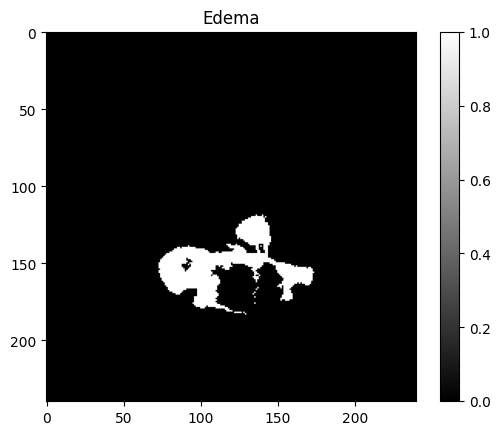

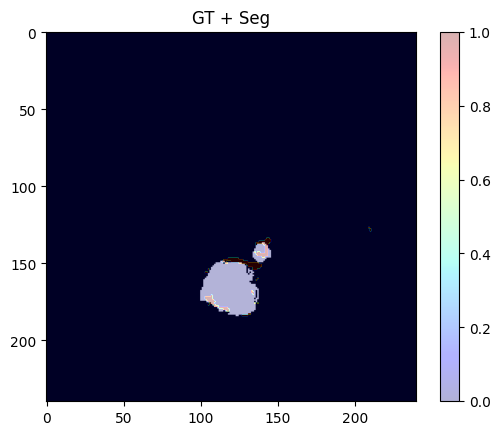

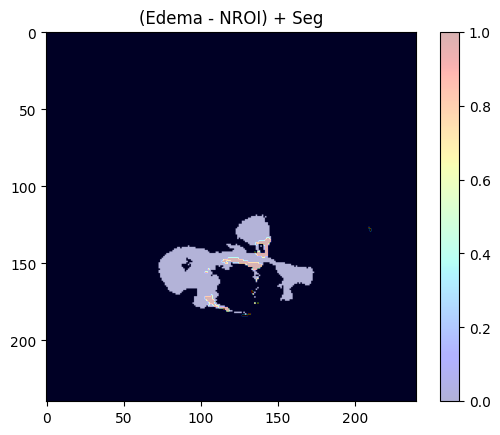

In [13]:
slice=80
# Create a figure with 3 subplots

GT_slice = ground_truth_mask [:, :, slice] #[0, :, :, 90]
#display_slice(GT_slice, title="GT")
Seg_slice = segmentation_mask [:, :, slice] #[0, :, :, 90]

display_slice(roi_mask[:, :, slice] , title="Edema")
#display_slice(Seg_slice, title="Seg")

display_slice_with_segmentation(GT_slice, Seg_slice, title="GT + Seg")

display_slice_with_segmentation(roi_mask[:, :, slice], Seg_slice, title="(Edema - NROI) + Seg")

In [15]:
roi_values_1 = [2]
roi_values_2 = [1, 4, 5, 6, 7, 8]
roi_values_3 = [2]
tp_=[]
fp_=[] 
fn_=[] 
tn_=[] 
sensitivity_=[]
precision_=[] 
specificity_=[]
accuracy_=[]
balanced_accuracy_=[]
dice_=[]

print(" ... procesando")
cases=[8, 16, 25, 29, 36]
for caso in cases : #range(1,37):# 37
    
    # Leer las máscaras de segmentación y ground truth
    if caso ==5 or caso == 17 or caso==20 or caso==28 or caso==35:
         continue

    segmentation_path = f'../Result_D/{caso}segmentation.nii.gz'
    ground_truth_path = f'../Dataset/recurrence_seg/{caso-1}segmentation.nii.gz'
    print(" ... procesando", segmentation_path)
        
    # Usando GT BratS deformado
    roi_path= f'../Result_D/{caso}segmentation_BraTS.nii.gz'#roi_paths[caso-1]
   
    segmentation_mask, segmentation_data = get_mask(segmentation_path, roi_values_1)
    ground_truth_mask, ground_truth_data = get_mask(ground_truth_path, roi_values_2)
    roi_mask, roi_data = get_mask(roi_path, roi_values_3)

    # Aplicar la ROI a las máscaras de segmentación y ground truth no enmarcado en edema
    # segmentation_mask_roi = segmentation_mask[roi_mask == 1]
    # ground_truth_mask_roi = ground_truth_mask[roi_mask == 1]

    # Sacar la Nroi de la máscara de ROI
    nroi_mask = get_Nroi(roi_data)
    #combined_mask = (roi_mask == 1) # enmarcado en Edema 
    #combined_mask = (roi_mask == 1) & (nroi_mask == 0) # enmarcado en Edema menos nroi
    combined_mask =  (nroi_mask == 0) # no enmarcado en edema menos nroi
    segmentation_mask_roi = segmentation_mask[combined_mask] #roi_mask == 1
    ground_truth_mask_roi = ground_truth_mask[combined_mask]

    # Aplanar los arrays para usarlos en confusion_matrix
    segmentation_mask_roi_flat = segmentation_mask_roi.flatten()
    ground_truth_mask_roi_flat = ground_truth_mask_roi.flatten()

    # Calcular TP, FP, TN, FN en la región definida por la ROI
    tn, fp, fn, tp = confusion_matrix(ground_truth_mask_roi_flat, segmentation_mask_roi_flat, labels=[0, 1]).ravel()
    sensitivity, specificity, precision, accuracy, balanced_accuracy, dice = calculate_metrics(tn, fp, fn, tp)

    # tp_.append(tp)
    # fp_.append(fp)
    # fn_.append(fn)
    sensitivity_.append(sensitivity)
    precision_.append(precision)
    specificity_.append(specificity)
    accuracy_.append(accuracy)
    balanced_accuracy_.append(balanced_accuracy)
    dice_.append(dice)

# Imprimir los resultados
print(f"sensivity: mean {np.mean(sensitivity_)}, std {np.std(sensitivity_)}") 
print(f"precision: mean {np.mean(precision_)}, std {np.std(precision_)}")
print(f"specificity: mean {np.mean(specificity_)}, std {np.std(specificity_)}")
print(f"accuracy: mean {np.mean(accuracy_)}, std {np.std(accuracy_)}")
print(f"balanced_accuracy: mean {np.mean(balanced_accuracy_)}, std {np.std(balanced_accuracy_)}")
print(f"dice: mean {np.mean(dice_)}, std {np.std(dice_)}")
    
      

 ... procesando
 ... procesando ../Result_D/8segmentation.nii.gz
 ... procesando ../Result_D/16segmentation.nii.gz
 ... procesando ../Result_D/25segmentation.nii.gz
 ... procesando ../Result_D/29segmentation.nii.gz
 ... procesando ../Result_D/36segmentation.nii.gz
sensivity: mean 0.04280715143927871, std 0.04674852268190534
precision: mean 0.40467240077334327, std 0.26682895574597687
specificity: mean 0.9996488650680575, std 0.00025675496922978003
accuracy: mean 0.9962267575792201, std 0.0014587686760287322
balanced_accuracy: mean 0.5212280082536681, std 0.02334274073752624
dice: mean 0.0730072236643575, std 0.07477757411277962


In [ ]:
# Aplanar los datos para calcular el histograma
# data_flat = segmentation_mask.flatten()
# data_flat = data_flat[data_flat != 0]

# # Crear el histograma
# plt.figure(figsize=(10, 6))
# plt.hist(data_flat, bins=10, color='blue', alpha=0.7)
# plt.title('Histograma de valores en el volumen de MRI')
# plt.xlabel('Valor')
# plt.ylabel('Frecuencia')
# plt.grid(True)
# plt.show()


In [140]:
# Calcular True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
def calcular_metricas(segmentation_mask, ground_truth_mask):
    tp = np.sum((segmentation_mask == 1) & (ground_truth_mask == 1))
    fp = np.sum((segmentation_mask == 1) & (ground_truth_mask == 0))
    fn = np.sum((segmentation_mask == 0) & (ground_truth_mask == 1))
    tn = np.sum((segmentation_mask == 0) & (ground_truth_mask == 0))

    # Calcular sensibilidad, precisión, accuracy y coeficiente Dice Specificity
    sensitivity = recall_score(ground_truth_mask.flatten(), segmentation_mask.flatten())
    precision = precision_score(ground_truth_mask.flatten(), segmentation_mask.flatten())
    accuracy = accuracy_score(ground_truth_mask.flatten(), segmentation_mask.flatten())
    balanced_accuracy = balanced_accuracy_score(ground_truth_mask.flatten(), segmentation_mask.flatten())
    dice = f1_score(ground_truth_mask.flatten(), segmentation_mask.flatten())
    # Calcular Specificity
    specificity = tn / (tn + fp)
    return tp, fp, fn, tn, sensitivity, precision, specificity, accuracy, balanced_accuracy, dice
tp, fp, fn, tn, sensitivity, precision, specificity, accuracy, balanced_accuracy, dice = calcular_metricas(segmentation_mask, ground_truth_mask)


# Imprimir resultados
print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')
print(f'True Negatives (TN): {tn}\n' )

print(f'Sensibilidad: {sensitivity}')
print(f'Precisión: {precision}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_accuracy}')
print(f'Coeficiente Dice: {dice}')


True Positives (TP): 1666
False Positives (FP): 5903
False Negatives (FN): 18493
True Negatives (TN): 8901938

Sensibilidad: 0.08264298824346446
Precisión: 0.22010833663627957
Specificity: 0.9993373253968049
Accuracy: 0.9972674731182796
Balanced Accuracy: 0.5409901568201346
Coeficiente Dice: 0.1201673398730525


In [ ]:
roi_values_1 = [2]
roi_values_2 = [1, 4, 5, 6, 7, 8]
tp_=[]
fp_=[] 
fn_=[] 
tn_=[] 
sensitivity_=[]
precision_=[] 
specificity_=[]
accuracy_=[]
balanced_accuracy_=[]
dice_=[]

for caso in range(1,37):
    
    # Leer las máscaras de segmentación y ground truth

    segmentation_path = f'../Result/{caso}segmentation.nii.gz'
    ground_truth_path = f'../Dataset/recurrence_seg/{caso-1}segmentation.nii.gz'
    print(segmentation_path, " ... procesando")
    
    segmentation_mask, segmentation_data = get_mask(segmentation_path, roi_values_1)
    ground_truth_mask, ground_truth_data = get_mask(ground_truth_path, roi_values_2)

    tp, fp, fn, tn, sensitivity, precision, specificity, accuracy, balanced_accuracy, dice = calcular_metricas(segmentation_mask, ground_truth_mask)
    tp_.append(tp)
    fp_.append(fp)
    fn_.append(fn)
    sensitivity_.append(sensitivity)
    precision_.append(precision)
    specificity_.append(specificity)
    accuracy_.append(accuracy)
    balanced_accuracy_.append(balanced_accuracy)
    dice_.append(dice)
    

In [137]:
# Obtener datos estadisticos de cada metrica
print(f"sensivity: mean {np.mean(sensitivity_)}, std {np.std(sensitivity_)}") 
print(f"precision: mean {np.mean(precision_)}, std {np.std(precision_)}")
print(f"specificity: mean {np.mean(specificity_)}, std {np.std(specificity_)}")
print(f"accuracy: mean {np.mean(accuracy_)}, std {np.std(accuracy_)}")
print(f"balanced_accuracy: mean {np.mean(balanced_accuracy_)}, std {np.std(balanced_accuracy_)}")
print(f"dice: mean {np.mean(dice_)}, std {np.std(dice_)}")

sensivity: mean 0.10116674498914002, std 0.09447344425925877
precision: mean 0.2500902667264293, std 0.2530348421932284
specificity: mean 0.9987275938233435, std 0.0007419349319962559
accuracy: mean 0.9957759389934289, std 0.002584368401822794
balanced_accuracy: mean 0.5499471694062418, std 0.04728167987142038
dice: mean 0.12486891096467165, std 0.11505305381875186
